# imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from patsy import dmatrices, dmatrix
import statsmodels.discrete.count_model as smdc

import bambi as bmb
import arviz as az
import pymc


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


https://www.statsmodels.org/stable/large_data.html#divide-and-conquer-distributing-jobs

In [2]:
import pyarrow.parquet as pq

class DataSet(dict):
    def __init__(self, path):
        self.filepath = path
        self.parquet = pq.ParquetFile(self.filepath)
    
    def __getitem__(self, key):
        try:
            return self.parquet.read([key]).to_pandas()[key]
        except:
            raise KeyError

    def __reduce__(self):
        #return self.parquet.read().to_pandas().__reduce__()
        return (self.__class__, (self.filepath, ))


In [3]:
import pyarrow as pa

In [4]:
# set some formatting preferences to make things nicer to read
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# load in and summarize

Count data from scMPRA performmed by Shendure lab, downloaded from GEO: GSE217686

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE217686

In [5]:
counts = pd.read_table('../../../data/GSE217686_assigned_oBC_CRE_mBC_joined_counts_sc_rep_mEB_series.txt')

In [6]:
counts[counts['UMIs_oBC']<10]

,cellBC,rep_id,oBC,mBC,CRE_class,CRE_id,reads_oBC,UMIs_oBC,reads_mBC,UMIs_mBC


- cellBC: cell barcode, 1 per cell no repeats
- rep_id: are these biological or technical replicates? Biological, but kinda both
- oBC: Tornado barcodes, circular RNA barcodes to indicate successful transfection of a given CRE into a given cell
- mBC: mRNA barcode for quantifying CRE activity 
- CRE_class: type of cis-regulatory element
- CRE_id: CRE identifier
- reads_oBC: 
- UMIs_oBC: 
- reads_mBC:
- UMIs_mBC: 

Questions/Notes to discuss with Mackenzie:
- bio vs tech reps?
- can a CRE-cell combo have more than one oBC-mBC pair? 
- can we just talk through which things can be used multiple times, which have more unique values than they are tagging and which combinations we're looking for? I think I have it all straight in my head but would be good to go through it with someone more familiar with the experimental side of things. 
- UMIs vs reads for these barcodes, the difference here is not clear to me. 
- by endogenous do they mean without inserted CREs in this case? 
- In some of Rohit's code I'm getting the sense that he's modeling the number of cells captured of each cell type is that the goal here?
- okay nevermind, I think cell type is a covariate for modeling counts per oBC 
- I can't track down this file where he got the cell type mappings from, any idea where that come from? 

In [7]:
counts.describe()

,reads_oBC,UMIs_oBC,reads_mBC,UMIs_mBC
count,877064.000,877064.000,877064.000,877064.000
mean,168.055,146.082,108.523,5.708
std,169.740,140.720,843.699,43.481
min,11.000,11.000,0.000,0.000
25%,61.000,55.000,0.000,0.000
50%,119.000,107.000,0.000,0.000
75%,217.000,190.000,0.000,0.000
max,5876.000,4616.000,60250.000,2890.000


In [8]:
counts.dtypes

cellBC       object
rep_id       object
oBC          object
mBC          object
CRE_class    object
CRE_id       object
reads_oBC     int64
UMIs_oBC      int64
reads_mBC     int64
UMIs_mBC      int64
dtype: object

In [9]:
counts.nunique()

cellBC       43447
rep_id           6
oBC          28938
mBC          28938
CRE_class        2
CRE_id         212
reads_oBC     2040
UMIs_oBC      1732
reads_mBC     8591
UMIs_mBC      1045
dtype: int64

In [10]:
counts

,cellBC,rep_id,oBC,mBC,CRE_class,CRE_id,reads_oBC,UMIs_oBC,reads_mBC,UMIs_mBC
0,A1_GTTACCCAGTTGAAGT-1,A1,GAAAGTGTATTTGGGT,ACGTAACATTATAAT,devCRE,Txndc12_chr4_7978,499,415,0,0
1,A1_GTTACCCAGTTGAAGT-1,A1,CCGGGGTAGGCGAAGA,AACTCAGACTACCAC,devCRE,Col1a2_chr6_72,510,414,0,0
2,A1_GTTACCCAGTTGAAGT-1,A1,ACTGACGTCAATCAAT,TGTTTAAGTCAACAA,devCRE,Klf4_chr4_3952,850,678,0,0
3,A1_GTTACCCAGTTGAAGT-1,A1,GGAGGTGTGCGCGTGG,CAACAACACATTTTA,devCRE,Foxa2_chr2_13840,549,451,0,0
4,A1_GTTACCCAGTTGAAGT-1,A1,CGATACCTACTTAATA,TACCTAATGGGAAAG,promoters,minP,413,353,0,0
...,...,...,...,...,...,...,...,...,...,...
877059,2B2_TTCTGTAAGGCTCTCG-1,2B2,AGCTGGTACACCCGAG,GAACAATTAAACGAG,devCRE,Sparc_chr11_7198,55,50,0,0
877060,2B2_TTCTGTAAGGCTCTCG-1,2B2,ATTTAGACACCAATAC,CAGCCCGCCGCCGAG,promoters,ubcP,32,31,196,11
877061,2B2_TGGAACTCAATCCTAG-1,2B2,GTTAGATACGCTATGG,ATGGCACATATCTTA,devCRE,Gata4_chr14_5760,21,18,0,0
877062,2B2_TGGAACTCAATCCTAG-1,2B2,GATTAATTCGGTCTAC,CTCTATCGTCCTCGT,devCRE,Lamb1_chr12_2289,13,13,0,0


- look into modeling/stats packages
- 

(1.0, 3034.4500000000003)

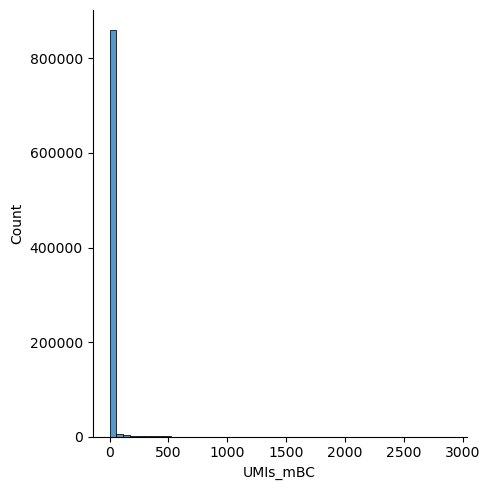

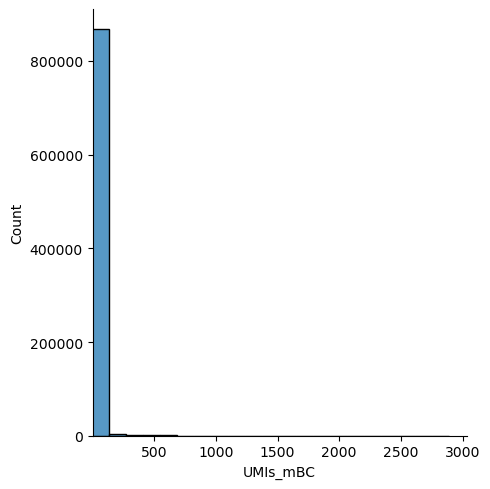

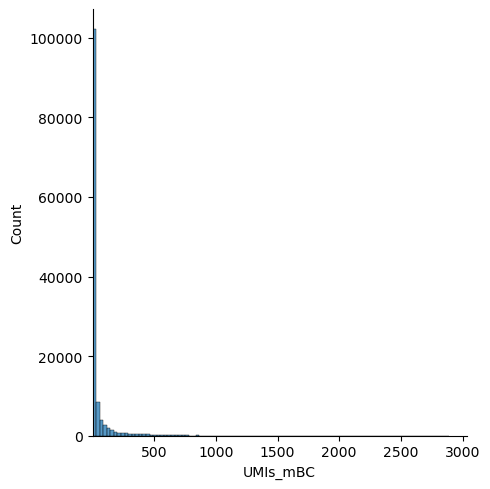

In [11]:
sns.displot(counts['UMIs_mBC'], bins = 50)

sns.displot(counts['UMIs_mBC'])
plt.xlim(1,)
sns.displot(counts['UMIs_mBC'][counts['UMIs_mBC']!=0], bins=100)
plt.xlim(1)

# Model choices

## statsmodels

GLMs: https://www.statsmodels.org/stable/glm.html

Regression with discrete dependent variable (includes zero-inflated models): https://www.statsmodels.org/stable/discretemod.html

To use this we'll probably want our scMPRA data class to have outcome/predictor attributes that can nicely go into this modeling framework (they call is endog/exog but that will just get confusing in this context). And maybe a way for the user to define what all they would like to be included in the predictor set. 

Patsy for making more complex design matrices: https://patsy.readthedocs.io/en/latest/formulas.html

In [12]:
counts

,cellBC,rep_id,oBC,mBC,CRE_class,CRE_id,reads_oBC,UMIs_oBC,reads_mBC,UMIs_mBC
0,A1_GTTACCCAGTTGAAGT-1,A1,GAAAGTGTATTTGGGT,ACGTAACATTATAAT,devCRE,Txndc12_chr4_7978,499,415,0,0
1,A1_GTTACCCAGTTGAAGT-1,A1,CCGGGGTAGGCGAAGA,AACTCAGACTACCAC,devCRE,Col1a2_chr6_72,510,414,0,0
2,A1_GTTACCCAGTTGAAGT-1,A1,ACTGACGTCAATCAAT,TGTTTAAGTCAACAA,devCRE,Klf4_chr4_3952,850,678,0,0
3,A1_GTTACCCAGTTGAAGT-1,A1,GGAGGTGTGCGCGTGG,CAACAACACATTTTA,devCRE,Foxa2_chr2_13840,549,451,0,0
4,A1_GTTACCCAGTTGAAGT-1,A1,CGATACCTACTTAATA,TACCTAATGGGAAAG,promoters,minP,413,353,0,0
...,...,...,...,...,...,...,...,...,...,...
877059,2B2_TTCTGTAAGGCTCTCG-1,2B2,AGCTGGTACACCCGAG,GAACAATTAAACGAG,devCRE,Sparc_chr11_7198,55,50,0,0
877060,2B2_TTCTGTAAGGCTCTCG-1,2B2,ATTTAGACACCAATAC,CAGCCCGCCGCCGAG,promoters,ubcP,32,31,196,11
877061,2B2_TGGAACTCAATCCTAG-1,2B2,GTTAGATACGCTATGG,ATGGCACATATCTTA,devCRE,Gata4_chr14_5760,21,18,0,0
877062,2B2_TGGAACTCAATCCTAG-1,2B2,GATTAATTCGGTCTAC,CTCTATCGTCCTCGT,devCRE,Lamb1_chr12_2289,13,13,0,0


In [13]:
cell_type_mapping = pd.read_table('../../../data/meb_cbc_to_cell_type_mapping.txt')

In [14]:
cell_type_mapping

,orig.ident,nCount_RNA,nFeature_RNA,percent_mt,seurat_clusters,annotation
A1_AAACCCAAGATGGGCT-1,repA1,890,540,6.292,1,Neuroectoderm (brain)
A1_AAACCCAAGGATTTGA-1,repA1,2311,1245,4.457,4,Ex. Endoderm (parietal)
A1_AAACCCAGTGCCTAAT-1,repA1,4180,1766,2.608,2,Mesoderm
A1_AAACCCAGTGTTAGCT-1,repA1,4597,2100,5.895,1,Neuroectoderm (brain)
A1_AAACCCAGTTCCGCTT-1,repA1,3747,1893,5.311,1,Neuroectoderm (brain)
...,...,...,...,...,...,...
2B2_TTTGTTGGTGCATTTG-1,rep2B2,4190,1822,2.840,5,Epiblast/primitive streak
2B2_TTTGTTGGTTCGGTTA-1,rep2B2,746,543,7.641,7,Neuroectoderm (rostral)
2B2_TTTGTTGTCAGGACAG-1,rep2B2,1961,1058,6.833,3,Surface Ectoderm
2B2_TTTGTTGTCCCTCAAC-1,rep2B2,814,539,5.897,3,Surface Ectoderm


In [15]:
counts['cell_type_annotation'] = np.array(cell_type_mapping.loc[counts['cellBC']]['annotation'])

In [16]:
counts

,cellBC,rep_id,oBC,mBC,CRE_class,CRE_id,reads_oBC,UMIs_oBC,reads_mBC,UMIs_mBC,cell_type_annotation
0,A1_GTTACCCAGTTGAAGT-1,A1,GAAAGTGTATTTGGGT,ACGTAACATTATAAT,devCRE,Txndc12_chr4_7978,499,415,0,0,Surface Ectoderm
1,A1_GTTACCCAGTTGAAGT-1,A1,CCGGGGTAGGCGAAGA,AACTCAGACTACCAC,devCRE,Col1a2_chr6_72,510,414,0,0,Surface Ectoderm
2,A1_GTTACCCAGTTGAAGT-1,A1,ACTGACGTCAATCAAT,TGTTTAAGTCAACAA,devCRE,Klf4_chr4_3952,850,678,0,0,Surface Ectoderm
3,A1_GTTACCCAGTTGAAGT-1,A1,GGAGGTGTGCGCGTGG,CAACAACACATTTTA,devCRE,Foxa2_chr2_13840,549,451,0,0,Surface Ectoderm
4,A1_GTTACCCAGTTGAAGT-1,A1,CGATACCTACTTAATA,TACCTAATGGGAAAG,promoters,minP,413,353,0,0,Surface Ectoderm
...,...,...,...,...,...,...,...,...,...,...,...
877059,2B2_TTCTGTAAGGCTCTCG-1,2B2,AGCTGGTACACCCGAG,GAACAATTAAACGAG,devCRE,Sparc_chr11_7198,55,50,0,0,Neuroectoderm (rostral)
877060,2B2_TTCTGTAAGGCTCTCG-1,2B2,ATTTAGACACCAATAC,CAGCCCGCCGCCGAG,promoters,ubcP,32,31,196,11,Neuroectoderm (rostral)
877061,2B2_TGGAACTCAATCCTAG-1,2B2,GTTAGATACGCTATGG,ATGGCACATATCTTA,devCRE,Gata4_chr14_5760,21,18,0,0,Mesoderm
877062,2B2_TGGAACTCAATCCTAG-1,2B2,GATTAATTCGGTCTAC,CTCTATCGTCCTCGT,devCRE,Lamb1_chr12_2289,13,13,0,0,Mesoderm


In [17]:
x_vars = counts[['cell_type_annotation','rep_id','CRE_class','CRE_id']]
y_vars = counts['UMIs_mBC']
simple_formula = "UMIs_mBC ~ C(cell_type_annotation) + C(rep_id) + C(CRE_class) + C(CRE_id)"

In [18]:
counts_groupby_cre = counts.groupby(by=['cellBC','rep_id','CRE_class','CRE_id','cell_type_annotation']).sum().reset_index()
counts_groupby_cre.shape

(778248, 11)

In [19]:
counts_groupby_cre.to_csv('shendure_counts_grouped.txt', sep='\t', index=False)

In [20]:
counts_groupby_cre.CRE_id.unique().shape

(212,)

In [21]:
counts_groupby_cre.cellBC.unique().shape

(43447,)

Text(0.5, 1.0, 'UMIs per CRE')

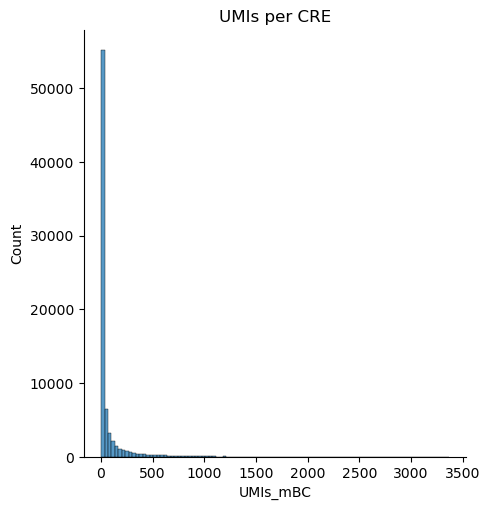

In [22]:
sns.displot(counts_groupby_cre[counts_groupby_cre.UMIs_mBC>1]['UMIs_mBC'], bins=100)
plt.title("UMIs per CRE")

# 'Big Data' efficiency 


Looking into using parquet format to speed up model fitting as suggested by statsmodels docs

https://www.statsmodels.org/stable/large_data.html

https://fastparquet.readthedocs.io/en/latest/

In [23]:

table = pa.Table.from_pandas(counts)
pq.write_table(table, '../../../data/shendure_mpra_counts_GSE217686.parq')
counts_parq = DataSet('../../../data/shendure_mpra_counts_GSE217686.parq')


table = pa.Table.from_pandas(counts_groupby_cre)
pq.write_table(table, '../../../data/shendure_mpra_counts_grouped_GSE217686.parq')
counts_parq_grouped = DataSet('../../../data/shendure_mpra_counts_grouped_GSE217686.parq')

# Troubleshooting array job 

In [24]:
import pyarrow.parquet as pq
import argparse
import statsmodels.discrete.count_model as smdc

class DataSet(dict):
    def __init__(self, path):
        print('initializing dataset')
        self.filepath = path
        self.parquet = pq.ParquetFile(self.filepath)
    
    def __getitem__(self, key):
        try:
            return self.parquet.read([key]).to_pandas()[key]
        except:
            raise KeyError

    def __reduce__(self):
        #return self.parquet.read().to_pandas().__reduce__()
        return (self.__class__, (self.filepath, ))


def poisson_model(counts_parq, patsy_formula):
    counts_model_poisson = smdc.GeneralizedPoisson.from_formula(formula = patsy_formula, data = counts_parq)

    return counts_model_poisson

def zi_poisson_model(counts_parq, patsy_formula):
    counts_model_zi_poisson = smdc.ZeroInflatedPoisson.from_formula(formula = patsy_formula, data = counts_parq)

    return counts_model_zi_poisson

def negative_binomial_model(counts_parq, patsy_formula):
    counts_model_negative_binomial = smdc.NegativeBinomialP.from_formula(formula = patsy_formula, data = counts_parq)

    return counts_model_negative_binomial

def zi_negative_binomial_model(counts_parq, patsy_formula):
    counts_model_zi_negative_binomial = smdc.ZeroInflatedNegativeBinomialP.from_formula(formula = patsy_formula, data = counts_parq)

    return counts_model_zi_negative_binomial

def get_stats(fit_model):
    print('getting stats')
    # available stats come from here https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.CountResults.html

    aic = fit_model.aic
    bic = fit_model.bic
    loglike = fit_model.llf
    llr_chi2 = fit_model.llr
    llr_chip = fit_model.llr_pvalue
    pseudr = fit_model.prsquared
    resid = fit_model.resid
    converged = fit_model.converged

    return [aic, bic, loglike, llr_chi2, llr_chip, pseudr, list(resid), converged]

def boolean_string(s):
    if s not in {'False', 'True'}:
        raise ValueError('Not a valid boolean string')
    return s == 'True'

In [25]:
scmpra_counts = DataSet('/home/eng26/project/scmpra/data/shendure_mpra_counts_grouped_GSE217686.parq')
formula = 'UMIs_mBC~C(cell_type_annotation)+C(rep_id)+C(CRE_id)'
maxiter = 10000
reg_fit = False
temp_dir = '/home/eng26/palmer_scratch/scmpra_temp'
model_choice = 'zi_negative_binomial'
out_file = 'poisson10000_False_UMIs_mBC~C(cell_type_annotation)+C(rep_id)+C(CRE_id)'

model_dict = {'poisson': poisson_model,
                'zi_poisson' : zi_poisson_model, 
                'negative_binomial' : negative_binomial_model,
                'zi_negative_binomial' : zi_negative_binomial_model}

initializing dataset


In [26]:
scmpra_counts.parquet

In [27]:
scmpra_model = model_dict[model_choice](scmpra_counts, formula)

In [30]:
try:
    scmpra_model = model_dict[model_choice](scmpra_counts, formula)
except:
    print('Failed to build %s model' % model_choice)


Failed to build zi_negetive_binomial model


In [34]:
scmpra_model_fit = scmpra_model.fit(maxiter=maxiter)

/home/eng26/.conda/envs/scmpra/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 0.730869
         Iterations: 206
         Function evaluations: 207
         Gradient evaluations: 207


In [10]:
model_info = [model_choice, formula, maxiter, reg_fit]
model_stats = get_stats(scmpra_model_fit)

getting stats


In [11]:
out_list = model_info + model_stats

In [12]:
out_list

['poisson',
 'UMIs_mBC~C(cell_type_annotation)+C(rep_id)+C(CRE_class)+C(CRE_id)',
 100,
 False,
 np.float64(1281281.1765441112),
 np.float64(1283933.5206446687),
 np.float64(-640413.5882720556),
 np.float64(388945.9532873763),
 np.float64(0.0),
 np.float64(0.23293341253289213),
 [-3.5899007890780954,
  -0.17229210154137642,
  -0.20680397440752868,
  -1.846708048816807,
  -0.38755591176779974,
  -0.35040838665550583,
  -1.1417888767688005,
  -32.58614468166748,
  -0.6384730271076221,
  -1.5745526416808433,
  -0.4121362384910442,
  -0.234287156724143,
  -1.3668775190471392,
  -0.10970803811060438,
  -0.9703169770181196,
  -0.35040838665550583,
  -1.6140345912715102,
  -1.028621883805993,
  -1.8540837726817367,
  -0.47932039344337785,
  -0.24764347884530688,
  -0.8372359843674642,
  -16.543588922488958,
  -0.6384730271076221,
  -0.47932039344337785,
  -0.15389132696107566,
  -0.4121362384910442,
  -0.3462908968992588,
  -2.0369204717906606,
  -11.586144681667477,
  -0.13016183401821446,
 

In [16]:
with open("%s/%s_stats.txt" % (temp_dir, out_file), "w") as o:
    o.write("\t".join(str(x) for x in out_list))

# Results of initial test run

In [24]:
test_stats = pd.read_table('/home/eng26/palmer_scratch/scmpra_temp/stats_initial_testing.txt')
test_stats

FileNotFoundError: [Errno 2] No such file or directory: '/home/eng26/palmer_scratch/scmpra_temp/stats_initial_testing.txt'

In [5]:
a = [0,1,2]

In [9]:
a[:-1]

[0, 1]

# Trying out Bambi on the real data

In [25]:
counts_groupby_cre

,cellBC,rep_id,CRE_class,CRE_id,cell_type_annotation,oBC,mBC,reads_oBC,UMIs_oBC,reads_mBC,UMIs_mBC
0,2B1_AAACCCACAAGGTTGG-1,2B1,devCRE,Btg1_chr10_9572,Neuroectoderm (brain),CATCGCTGAGTAAACG,GCGTACTCACCAGGT,73,67,0,0
1,2B1_AAACCCACAAGGTTGG-1,2B1,devCRE,Gata4_chr14_5710,Neuroectoderm (brain),GAGGATGAGTTGGAAT,CAATCGCACCCCCGA,167,159,0,0
2,2B1_AAACCCACAAGGTTGG-1,2B1,devCRE,Klf4_chr4_3952,Neuroectoderm (brain),CGTGAATTAATTCTAT,AACCCGGTAAATGTA,99,89,0,0
3,2B1_AAACCCACAAGGTTGG-1,2B1,devCRE,Lama1_chr17_7793,Neuroectoderm (brain),AGTAAGTCAGCTCTTT,CGTGACCTCTTCATT,159,147,0,0
4,2B1_AAACCCACAAGGTTGG-1,2B1,devCRE,Sox17_chr1_67,Neuroectoderm (brain),GACAATAAAATTCCAT,ACAGTCACAAATTTA,59,58,0,0
...,...,...,...,...,...,...,...,...,...,...,...
778243,B2_TTTGTTGGTGGACCAA-1,B2,devCRE,Sparc_chr11_7207,Ex. Endoderm (visceral),AATAATCACTCAAATT,TACCAACTGAGACAT,130,104,0,0
778244,B2_TTTGTTGGTGGACCAA-1,B2,devCRE,Tgfbi_chr13_5735,Ex. Endoderm (visceral),AGTCCATGGAGGGAGG,GTTTACCACATTACT,108,98,0,0
778245,B2_TTTGTTGGTGGACCAA-1,B2,devCRE,Tgfbi_chr13_5741,Ex. Endoderm (visceral),CTCAAGTTAGTAAGGG,CAGGGAACTGCCACC,75,68,19,1
778246,B2_TTTGTTGGTGGACCAA-1,B2,promoters,noP,Ex. Endoderm (visceral),ACTTCTCGCCAAGGAAGTTTCTTCGTCTGCCC,TCCCGCTGACACTTAATGTGGGTCGTCTAT,200,166,0,0


In [25]:
counts_groupby_cre.cell_type_annotation.value_counts()

cell_type_annotation
Pluripotent                  165773
Neuroectoderm (brain)        135976
Mesoderm                     128596
Surface Ectoderm              86927
Ex. Endoderm (parietal)       77898
Epiblast/primitive streak     66949
Ex. Endoderm (visceral)       51713
Neuroectoderm (rostral)       30630
Haematoendothelial            21749
Cardiomyocytes                12037
Name: count, dtype: int64

In [24]:
pluri = counts_groupby_cre[counts_groupby_cre.cell_type_annotation=='Pluripotent']
pluri

,cellBC,rep_id,CRE_class,CRE_id,cell_type_annotation,oBC,mBC,reads_oBC,UMIs_oBC,reads_mBC,UMIs_mBC
158,2B1_AAACCCAGTATCGCGC-1,2B1,devCRE,Bend5_chr4_8172,Pluripotent,ATTTCTGGCGGGGTTC,CCAATACTTAAACAC,85,79,0,0
159,2B1_AAACCCAGTATCGCGC-1,2B1,devCRE,Cdk5r1_chr11_12559,Pluripotent,GTCGGCAACGCAGGAG,ACCCATCGACCGACC,34,30,62,4
160,2B1_AAACCCAGTATCGCGC-1,2B1,devCRE,Col1a1_chr11_15307,Pluripotent,GTATAGGTGAACCAAG,CCCTTAGATAGGCCC,119,109,0,0
161,2B1_AAACCCAGTATCGCGC-1,2B1,devCRE,Col5a1_chr2_2575,Pluripotent,GGTTCTGTCTCAGAAT,TATATTGAGGGTTAC,61,58,0,0
162,2B1_AAACCCAGTATCGCGC-1,2B1,devCRE,Col5a1_chr2_2576,Pluripotent,GTGACATACTAAAATT,ATATCGAAAACATTA,135,130,0,0
...,...,...,...,...,...,...,...,...,...,...,...
778149,B2_TTTGTTGAGTATGACA-1,B2,devCRE,Foxa2_chr2_13856,Pluripotent,GGGAAGCCCGCGAGGG,GCACCTCTGACCCCA,748,641,0,0
778150,B2_TTTGTTGAGTATGACA-1,B2,devCRE,Gata4_chr14_5677,Pluripotent,GGAAAGACGTTTAGTA,TGCAAACATCCCCAC,587,493,239,11
778151,B2_TTTGTTGAGTATGACA-1,B2,devCRE,Gata4_chr14_5776,Pluripotent,AGTTGTACGTTGCGAA,CTGAAAACAAACAGA,559,485,0,0
778152,B2_TTTGTTGAGTATGACA-1,B2,promoters,minP,Pluripotent,CCTTAGGAAGACATGT,CGGCCCAAGCGGGCC,575,478,0,0


In [25]:
pluri.to_csv('shendure_counts_grouped_pluri.txt', sep='\t', index=False)

In [26]:
cardio = counts_groupby_cre[counts_groupby_cre.cell_type_annotation=='Cardiomyocytes']

In [27]:
cardio.to_csv('shendure_counts_grouped_cardio.txt', sep='\t', index=False)

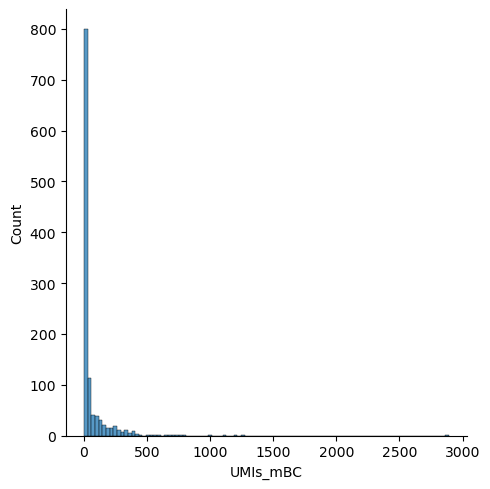

In [27]:
sns.displot(cardio[cardio.UMIs_mBC>1]['UMIs_mBC'], bins=100)

In [28]:
simple_formula

'UMIs_mBC ~ C(cell_type_annotation) + C(rep_id) + C(CRE_class) + C(CRE_id)'

In [29]:
#model = bmb.Model(simple_formula, cardio, family = "poisson")
#model = bmb.Model(simple_formula, cardio, family = "poisson", priors = {"CRE_id": bmb.Prior("Poisson")})
model = bmb.Model("UMIs_mBC~1", cardio, family = "poisson")

In [30]:
model

       Formula: UMIs_mBC~1
        Family: poisson
          Link: mu = log
  Observations: 12037
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)

In [31]:
model_fit = model.fit(draws = 1000, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [Intercept]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.


In [32]:
model_sum = az.summary(model_fit)
model_sum

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.760,0.004,1.753,1.767,0.000,0.000,3378.000,5489.000,1.000


In [33]:
model.predict(model_fit, kind="response")



<Axes: xlabel='UMIs_mBC'>

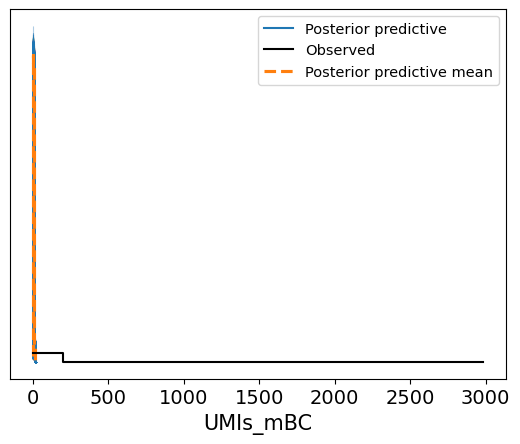

In [34]:
az.plot_ppc(model_fit)